In [1]:
import scanpy as sc

In [2]:
#settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(color_map='viridis')
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [3]:
#results file
results_file = '/Users/rvi33352/Documents/sc RNA seq analysis/results files/JupyterLW_Scanpy.h5ad'  # the file that will store the analysis results

In [4]:
#read h5 OR h5ac
adata = sc.read_10x_h5(filename = '/Users/rvi33352/Documents/sc RNA seq analysis/Phex/WT/filtered_feature_bc_matrix.h5')
#adata = sc.read_h5ad(filename = '/Users/renevielman/OneDrive - Creighton University/Creighton/scRNAseq/Scanpy/Conversion.h5ad')
adata

reading /Users/rvi33352/Documents/sc RNA seq analysis/Phex/WT/filtered_feature_bc_matrix.h5
 (0:00:00)


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9719 × 33696
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
adata.var_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


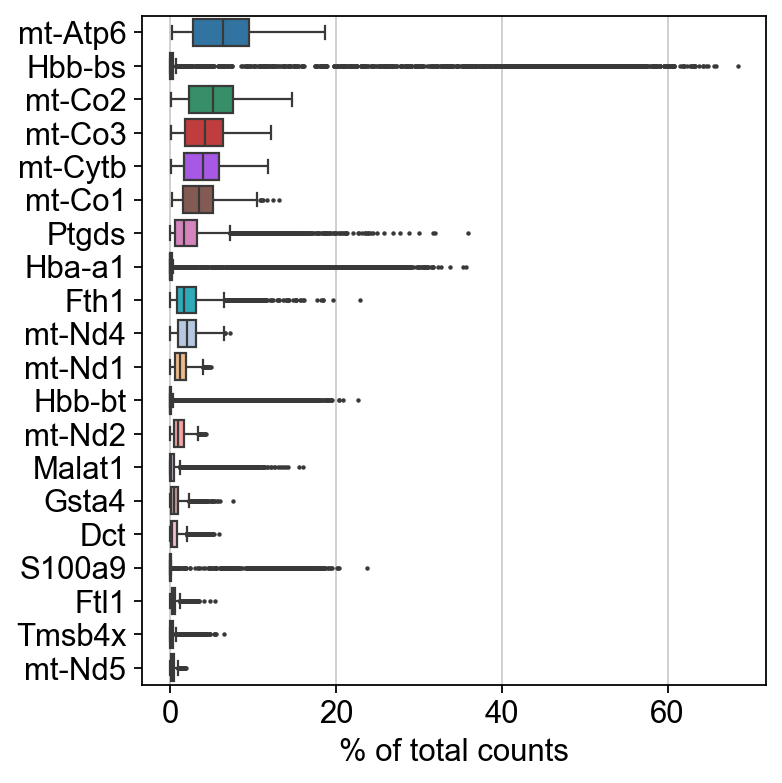

In [6]:
#highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20, )

filtered out 542 cells that have less than 200 genes expressed
filtered out 14069 genes that are detected in less than 3 cells


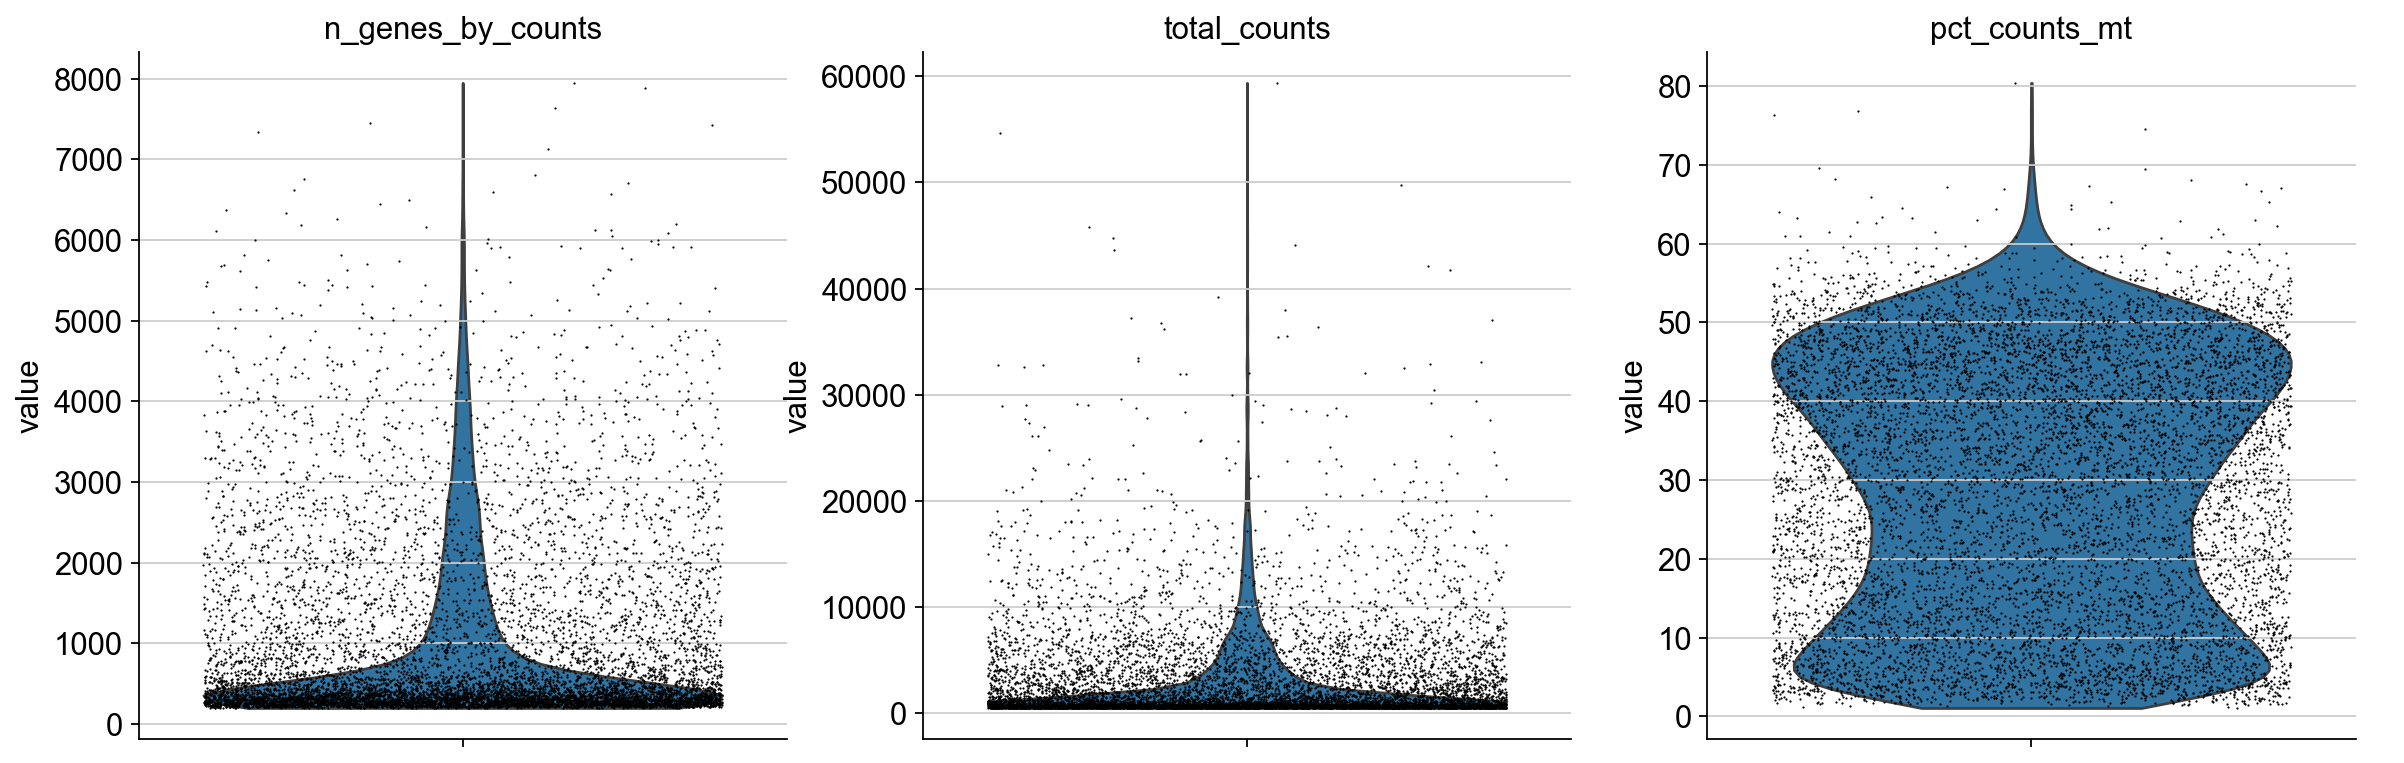

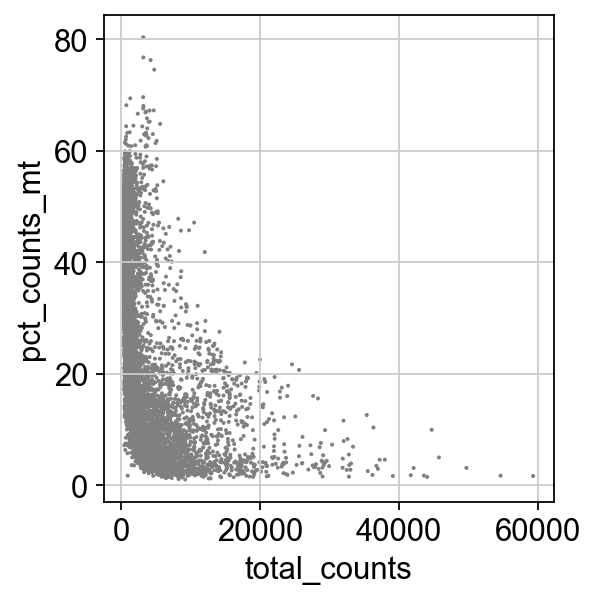

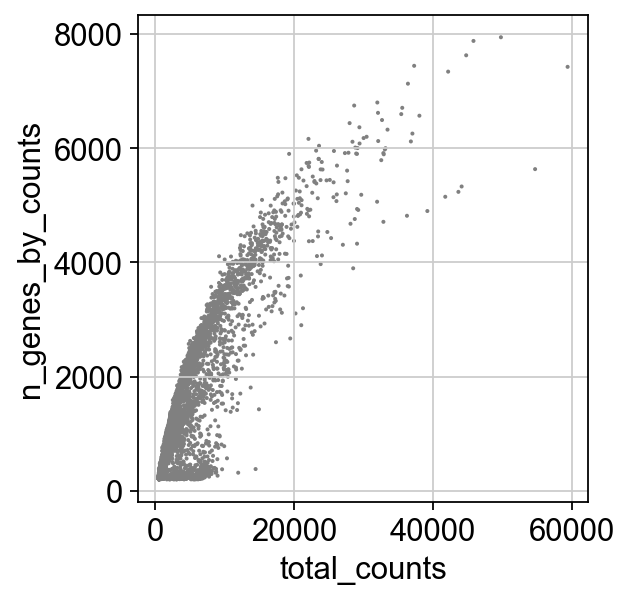

In [7]:
#filtering and normalization
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
#adata = adata[adata.obs.pct_counts_mt < 10, :]


In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


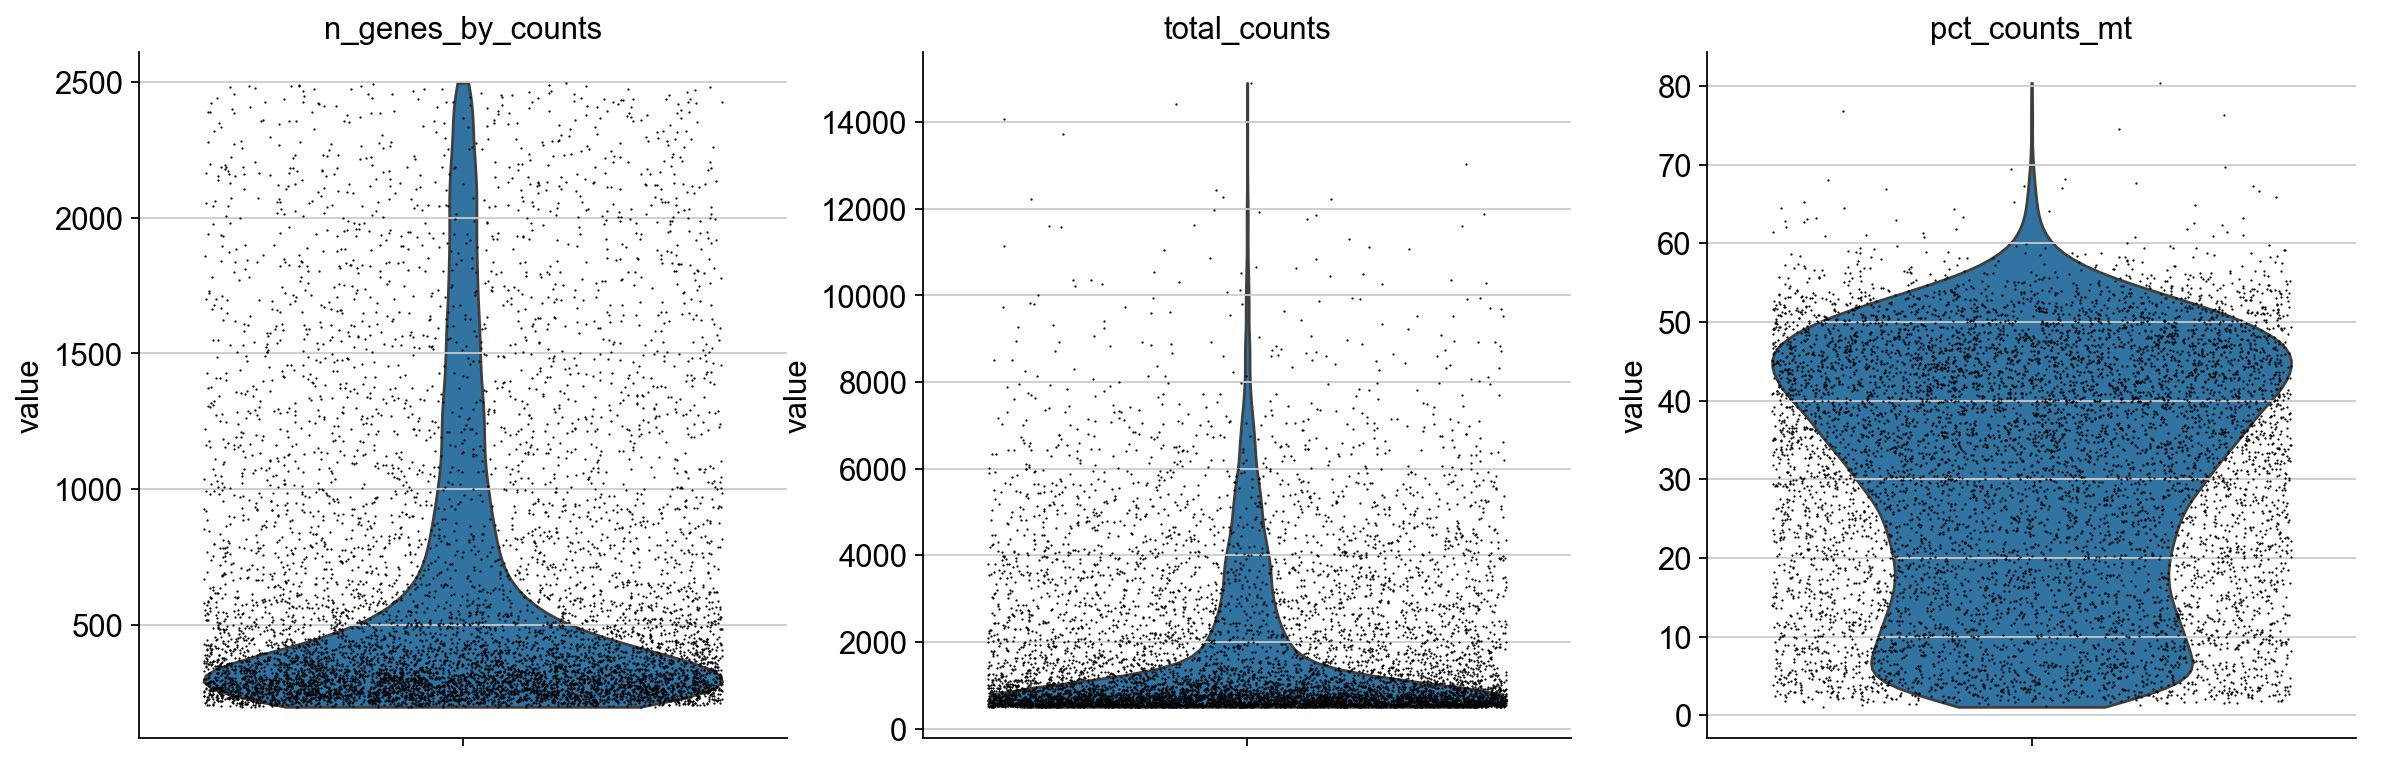

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


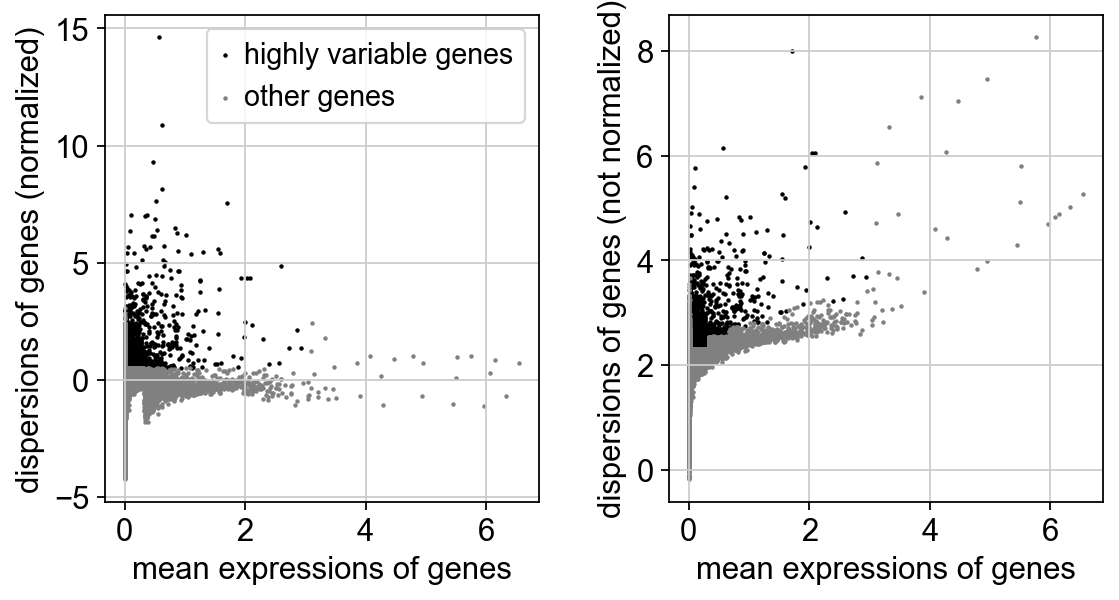

In [11]:
#identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 8173 × 19627
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [13]:
#set raw data
adata.raw = adata

In [14]:
#filtering, regression and scaling
adata = adata[:, adata.var.highly_variable]

In [15]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [16]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=20


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


    finished (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [18]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


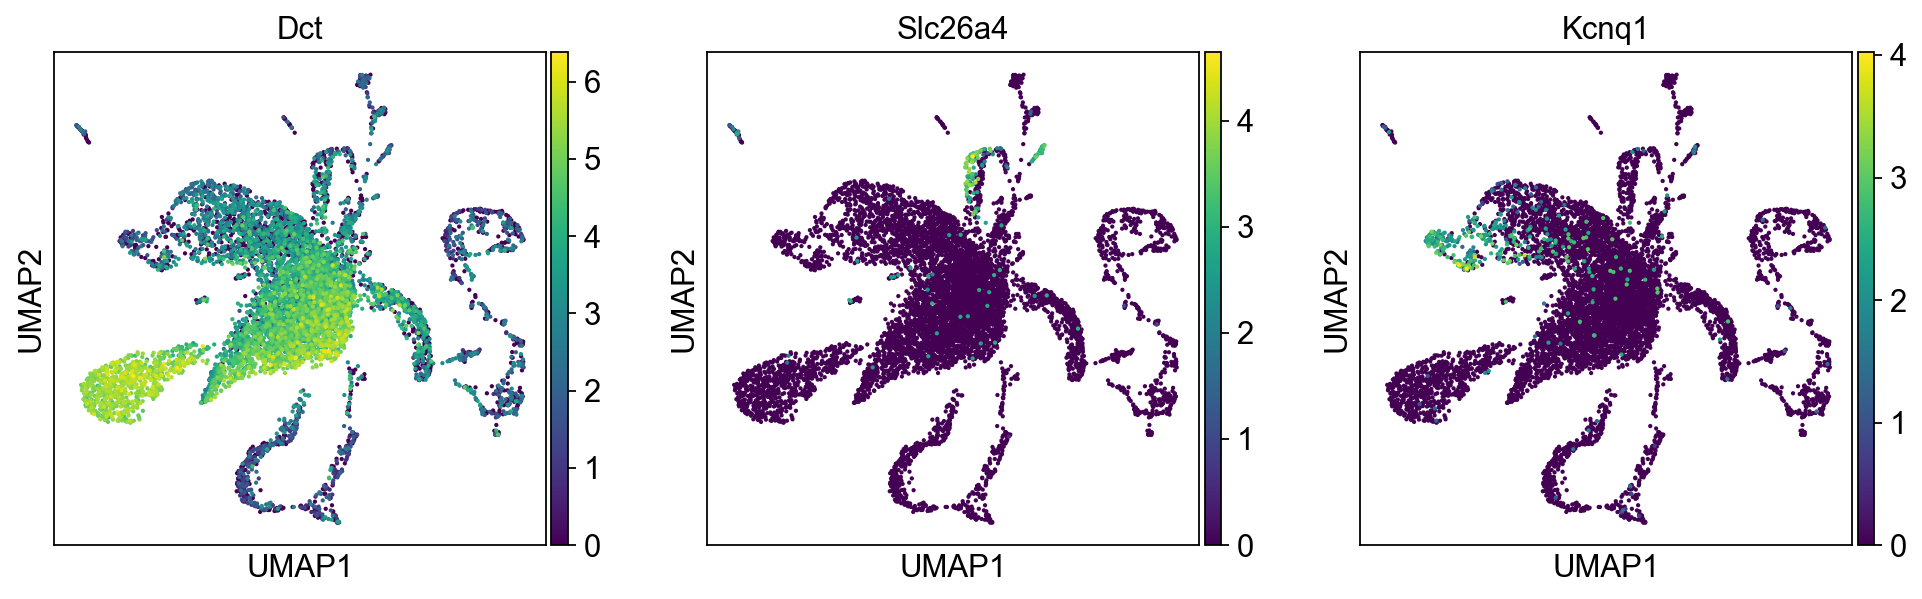

In [19]:
sc.tl.umap(adata) 
sc.pl.umap(adata, color=['Dct', 'Slc26a4', 'Kcnq1']) 

In [20]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


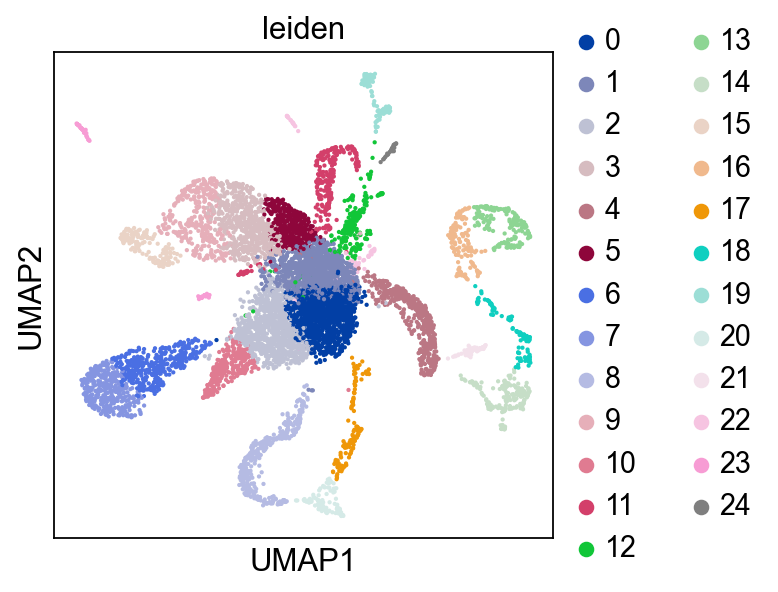

In [21]:
sc.pl.umap(adata, color = 'leiden')

In [22]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res,
    )

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res_0.02', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 42 clusters and added
    'leiden_res_2.00', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

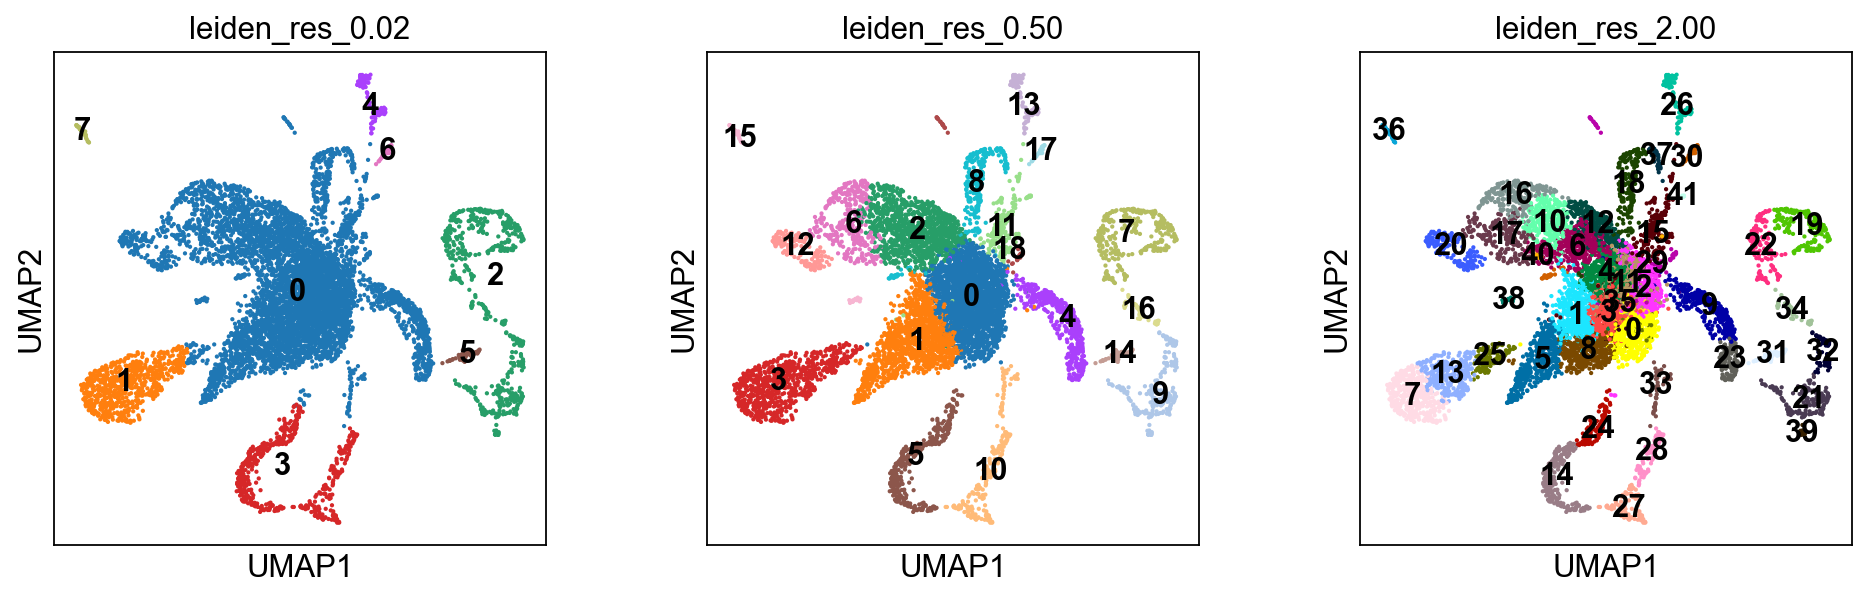

In [23]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

In [39]:
marker_genes = {
    "Marginal": ["Kcne1", "Kcnq1", "Atp1b2", "Slc12a2"],
    "Intermediate": ["Kcnj10", "Met", "Ednrb", "Dct", "Pax3", "Cd44", "Nrp2", "Tyr"],
    "Basal": ["Gjb2", "Cldn11", "Tjp1", "Atp6v0a4"],
    "Spindle/Root Cells": ["Slc26a4", "Anxa1", "Epyc"],
    "Fibrocytes": ["Otos", "Car3", "Car2", "Slc12a2", "Gjb2", "Igfbp2"],
    "Endothelial Cells": ["Esam", "Pecam1"],
    "Pericytes": ["Rgs5"],
    "Smooth Muscle": ["Tagln", "Anxa1", "Myh11"],
    "Macrophages": ["Cx3cr1"],
    "CD14+ Mono": ["Cd14"],
    "CD16+ Mono": ["Tcf7l2", "Lyn"],
    "Erythroblast": ["Mki67"],
    "NK": ["Nkg7", "Cd247", "Fcer1g", "Tyrobp"],
    "Naive CD20+ B": ["Ms4a1", "Ighd", "Fcrl1", "Ighm"],
    "B cells": ["Ms4a1", "Itgb1", "Col4a4", "Prdm1", "Irf4", "Pax5", "Bcl11a", "Blk", "Ighd", "Ighm"],
    "Plasma cells": ["Mzb1", "Hsp90b1", "Fndc3b", "Prdm1", "Igkc", "Jchain"],
    "Plasmablast": ["Xbp1", "Prdm1", "Pax5"],
    "CD4+ T": ["Cd4", "Il7r", "Trbc2"],
    "CD8+ T": ["Cd8a", "Gzma", "Ccl5", "Gzmb"],
    "T naive": ["Lef1", "Ccr7", "Tcf7"],
    "Neutrophils": ["Stfa2l1", "Ly6g"],
    "Reissner's Membrane": ["Vmo1"],
    "TBC": ["Coch", "Emilin2"],
    "Spiral ligament": ["Slc1a3"],
    "Supporting Cells": ["Sox2", "Cdkn1b"],
    "Hair Cells": ["Otof", "Ocm",],
    "Schwann Cells": ["Mpz", "Mbp", "Plp1"],
    "SGNs": ["Nefh", "Thy1", "Tubb3"]
 }

/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be igno

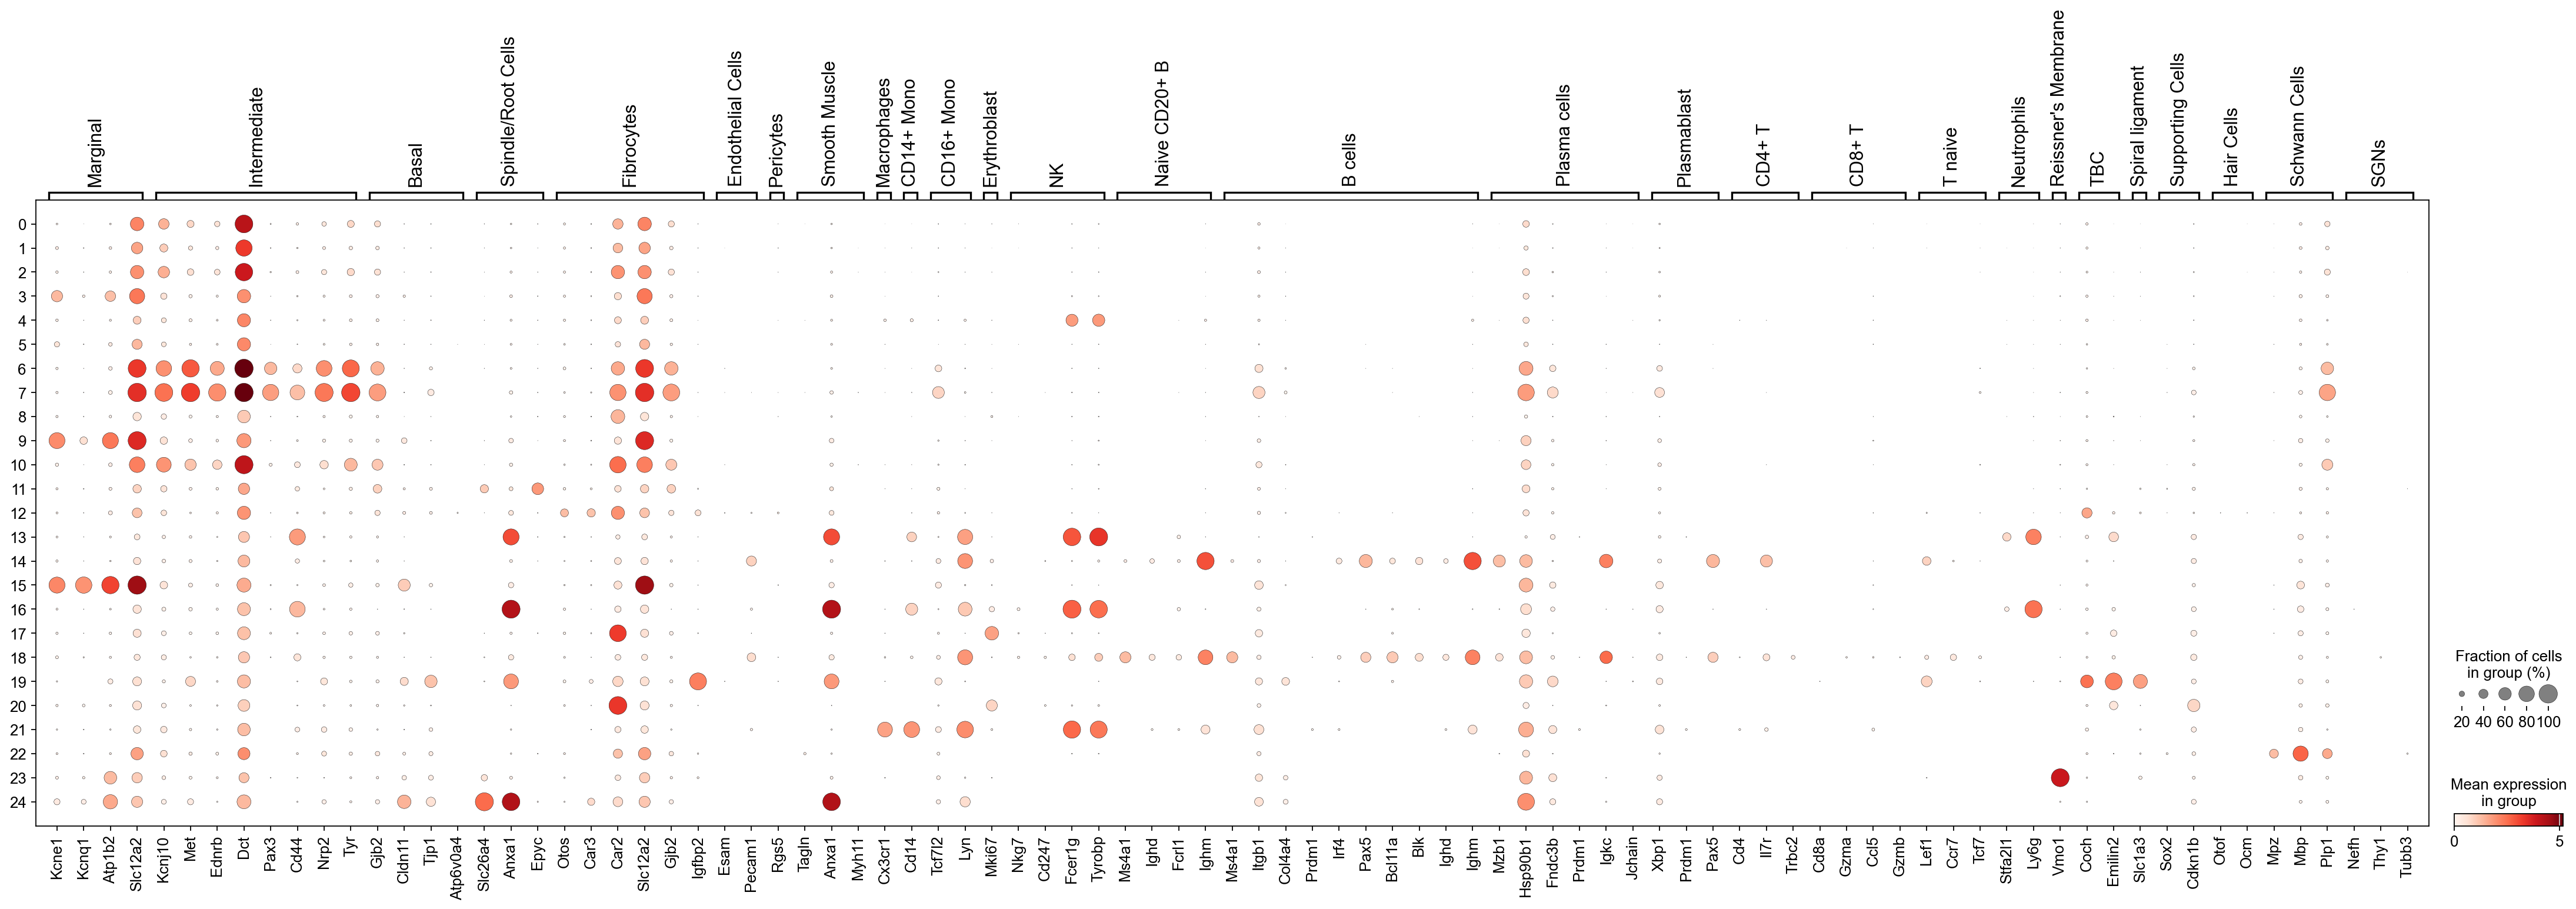

In [40]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be igno

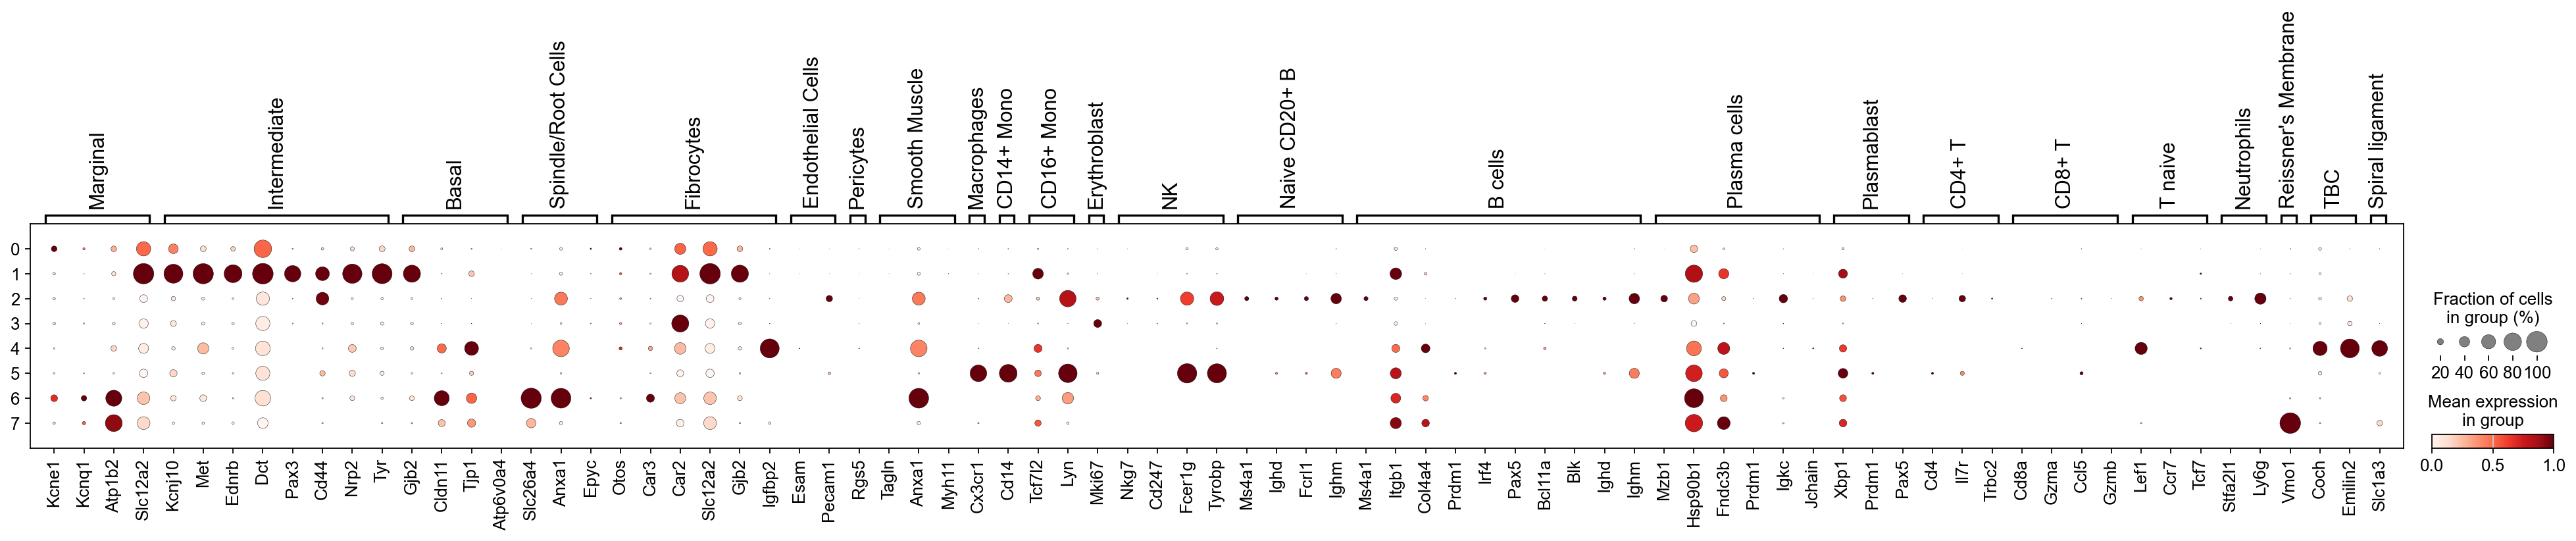

In [26]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be igno

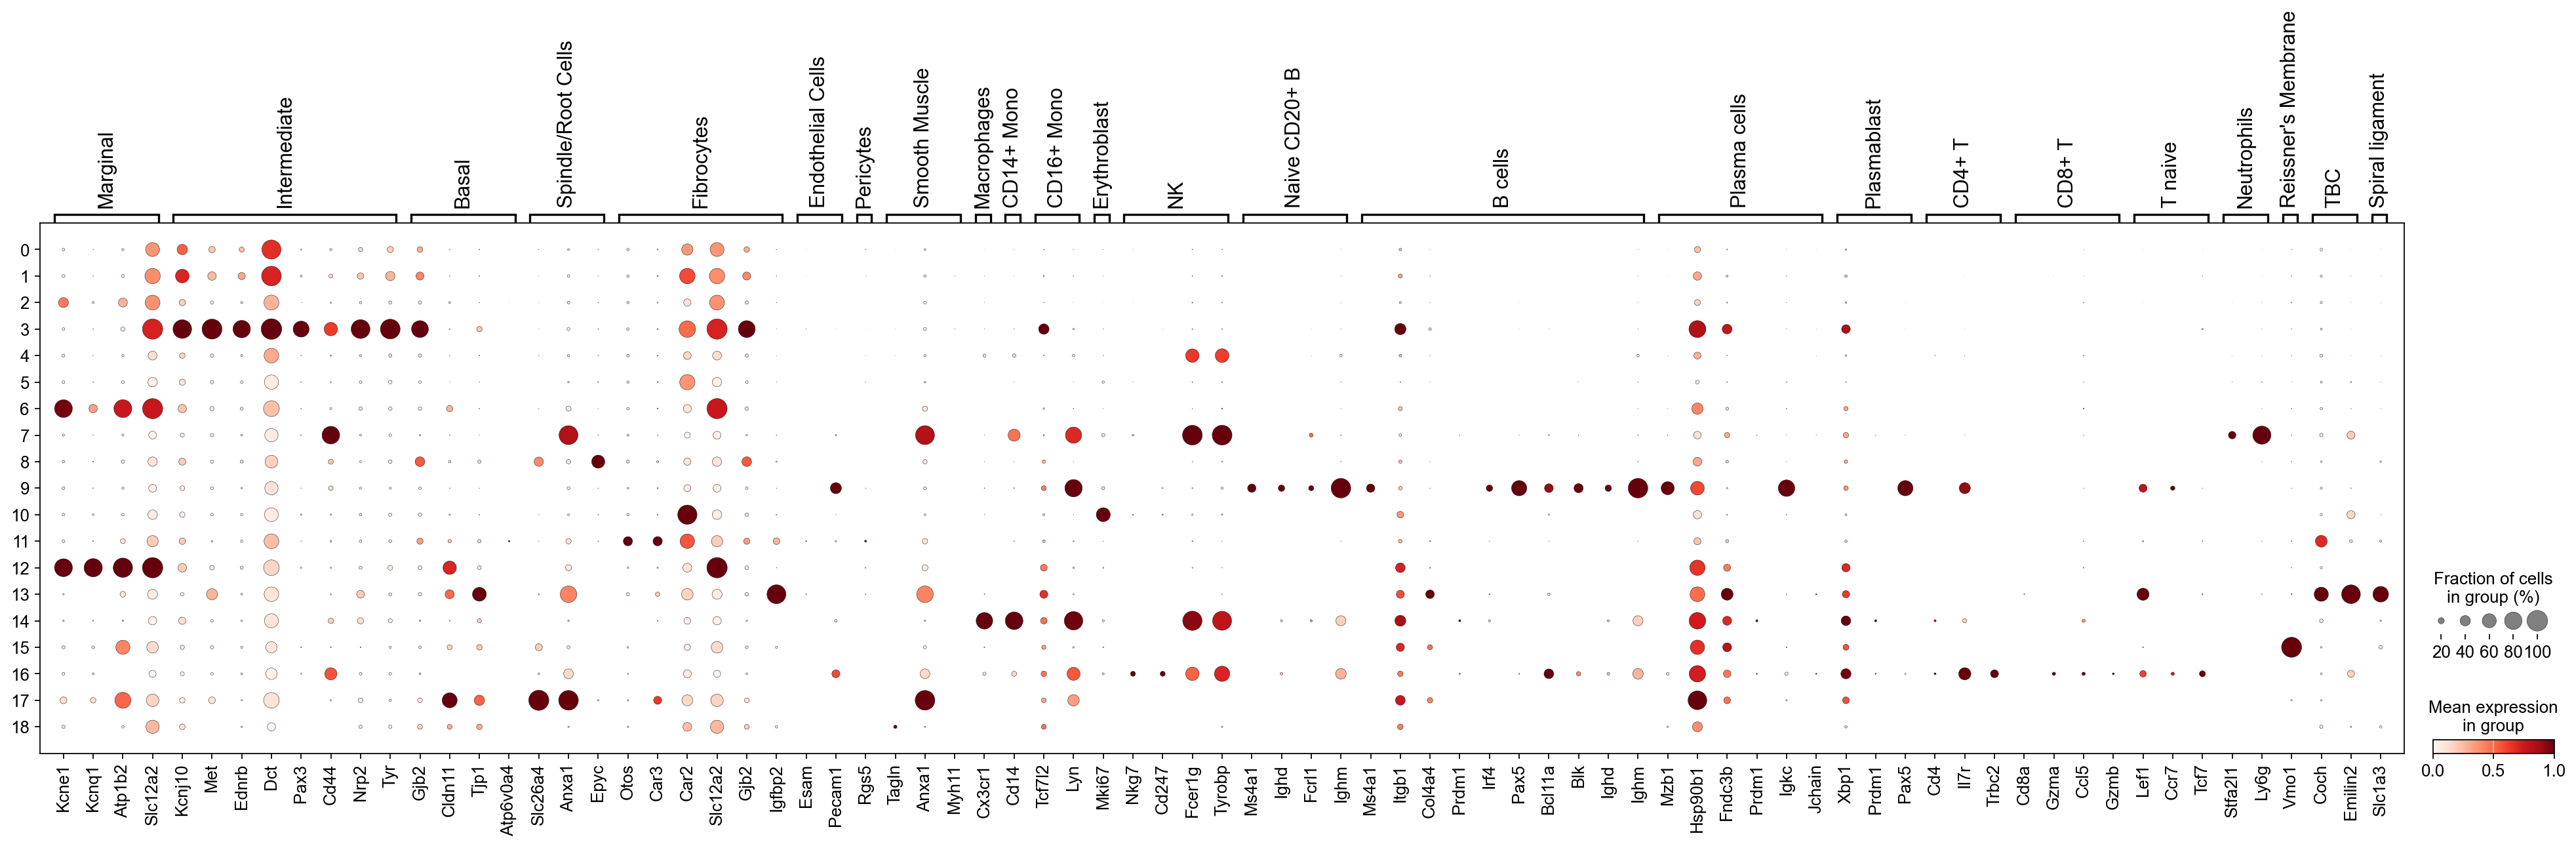

In [27]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


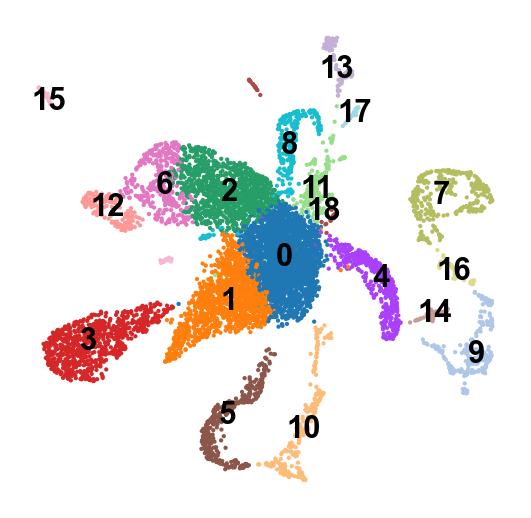

In [28]:
sc.pl.umap(adata, color='leiden_res_0.50', legend_loc='on data', title='', frameon=False)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.50']`
categories: 0, 1, 2, etc.
var_group_labels: Marginal, Intermediate, Basal, etc.


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version

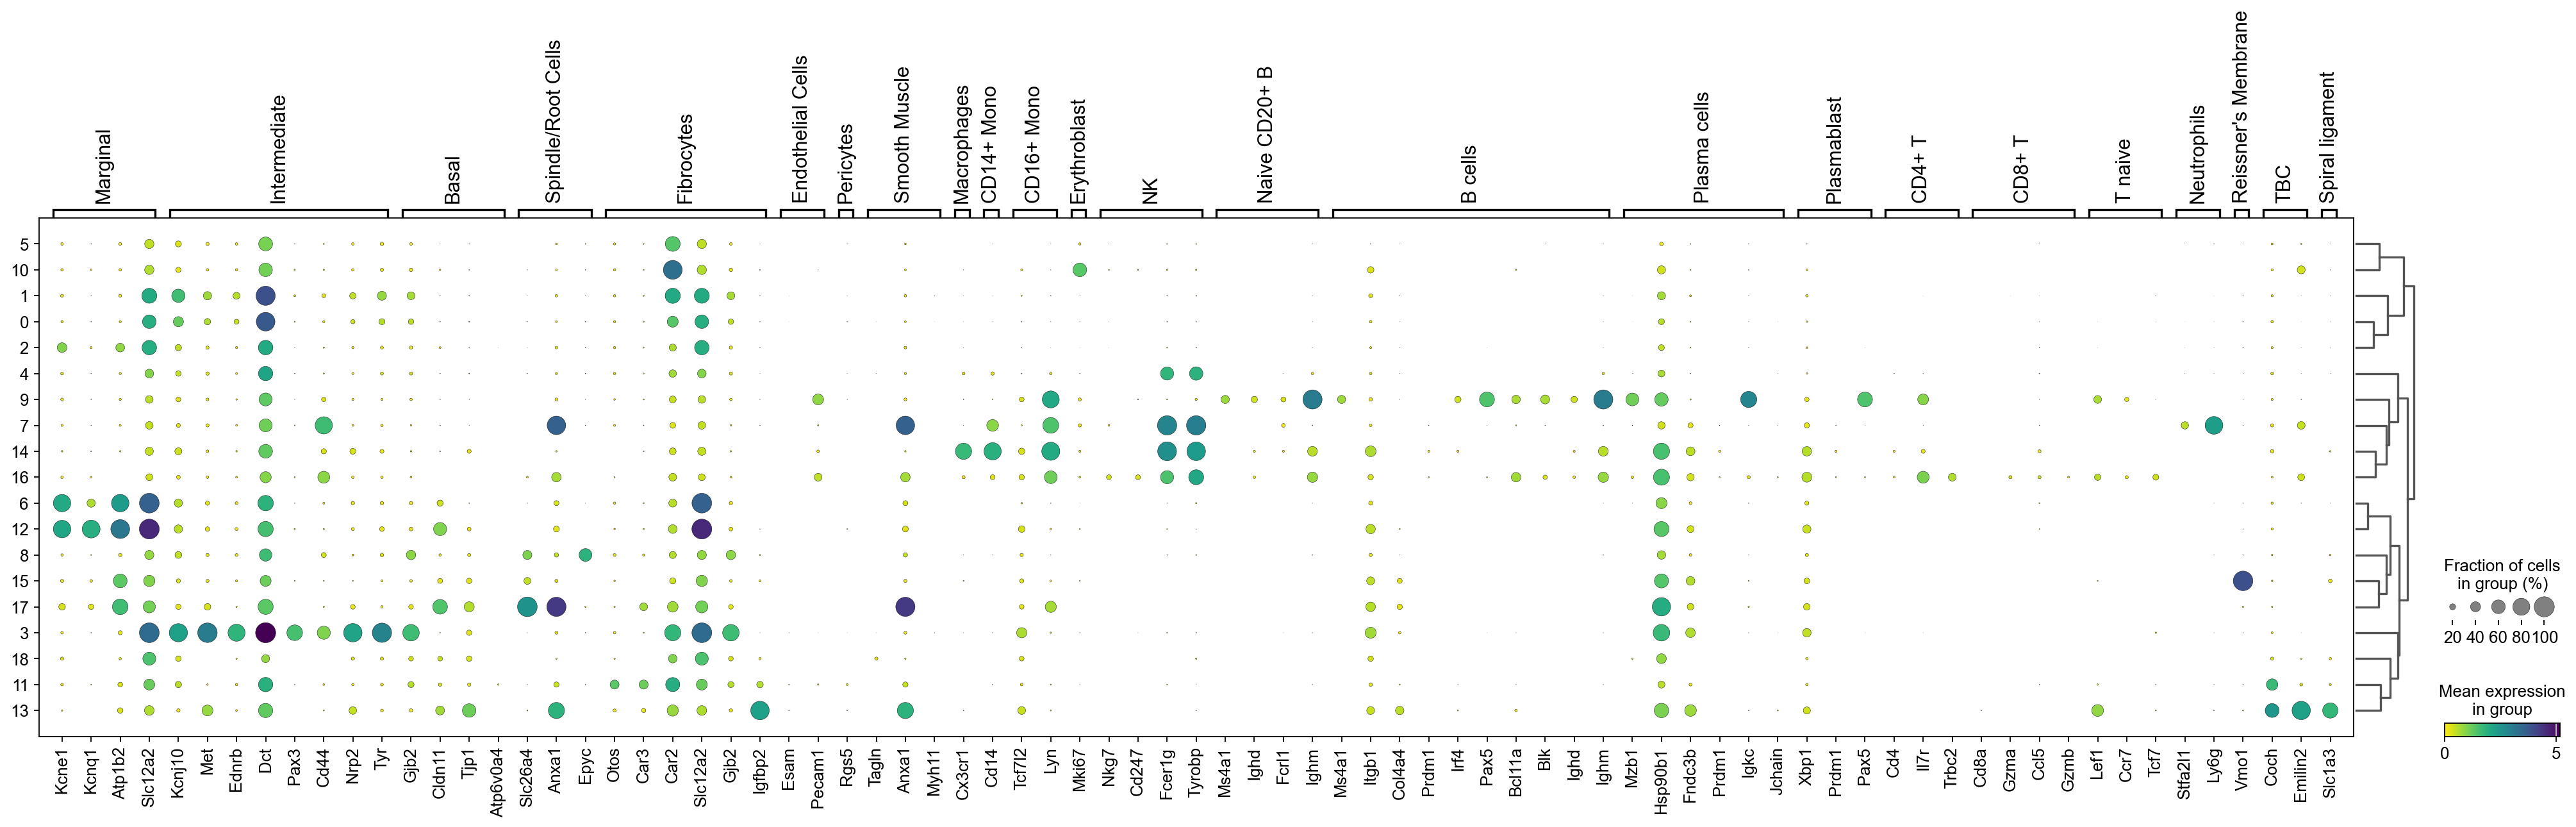

In [29]:
sc.tl.dendrogram(adata, groupby='leiden_res_0.50')
sc.pl.dotplot(adata, marker_genes, groupby='leiden_res_0.50', dendrogram=True,
                      cmap='viridis_r');

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.50']`
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Marginal, Intermediate, Basal, etc.


/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version

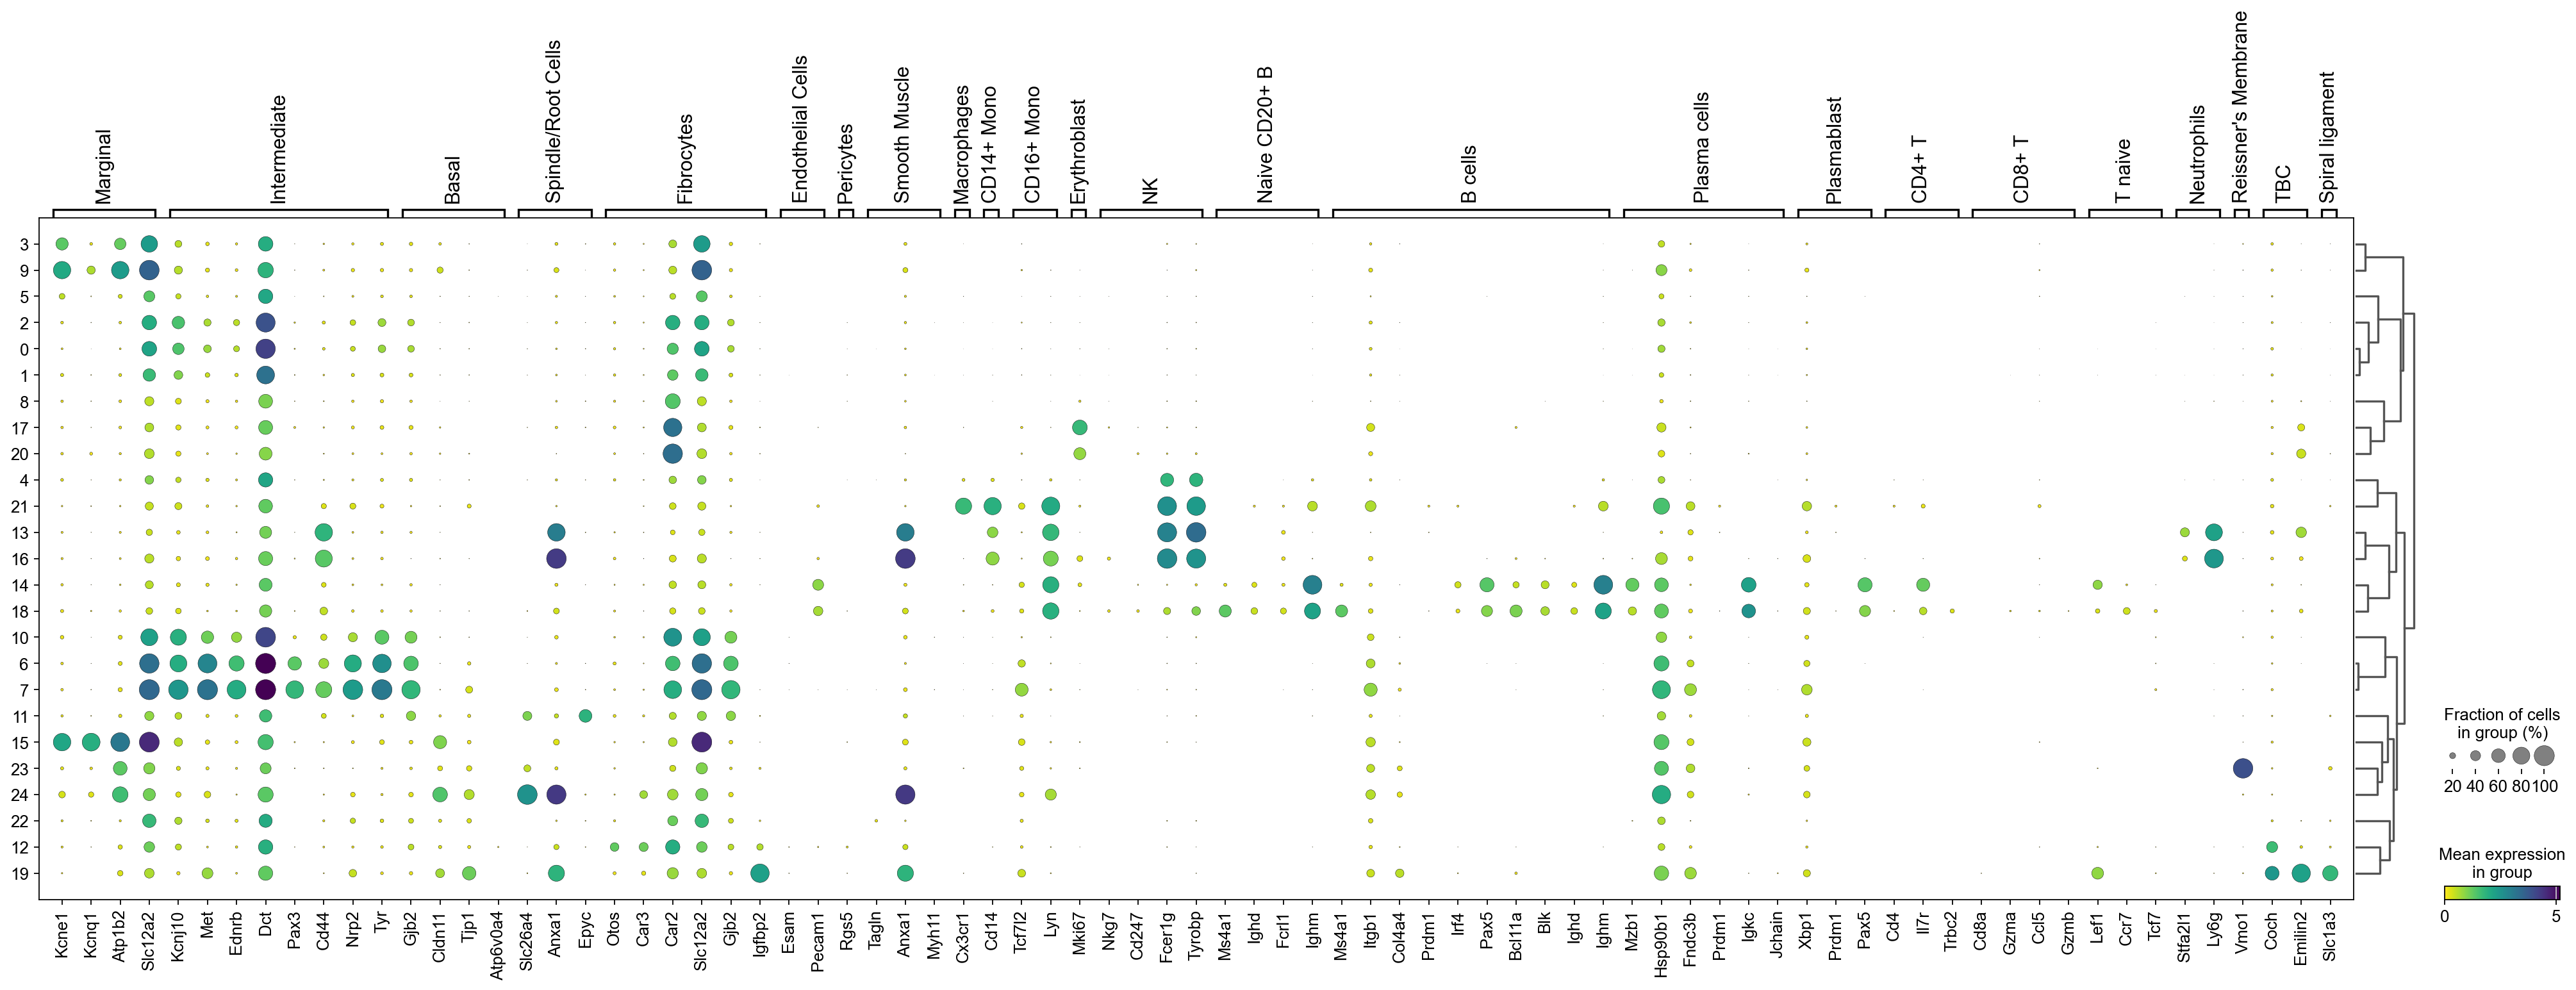

In [30]:
sc.tl.dendrogram(adata, groupby='leiden_res_0.50')
sc.pl.dotplot(adata, marker_genes, groupby='leiden', dendrogram=True,
                      cmap='viridis_r');

In [31]:
#rename clusters
#new_cluster_names = ['0', '1', '2', 'Intermediate Cells', '4', '5', '6', '7',
                    #'8', '9', '10', '11', '12', '13', 
                    #'14', '15', '16', '17', '18']
#adata.rename_categories('leiden_res_0.50', new_cluster_names)

/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/rvi33352/miniforge3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

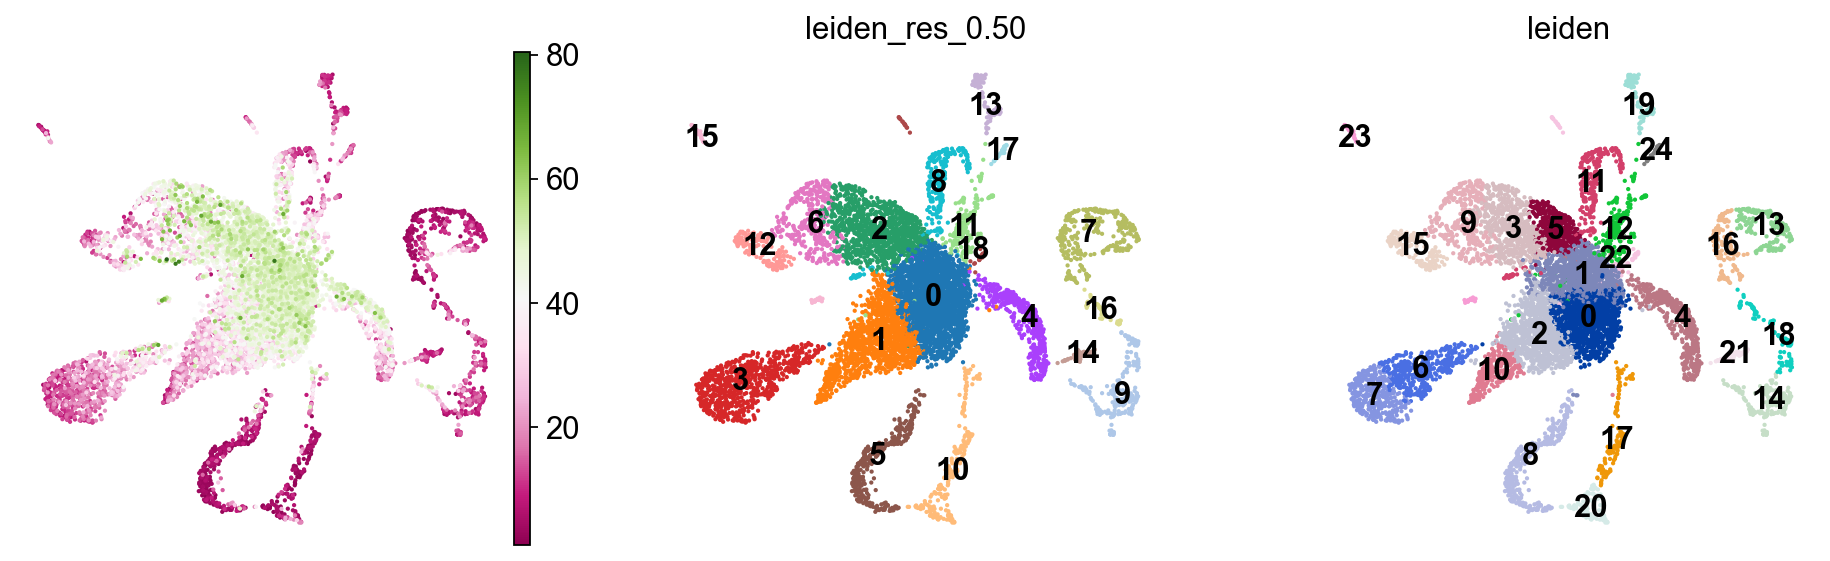

In [32]:
sc.pl.umap(adata, color=['pct_counts_mt', 'leiden_res_0.50'], legend_loc='on data', title='', cmap='PiYG',frameon=False)